In [1]:
# Imports
%matplotlib widget
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba
import matplotlib.colors as mcolors
from matplotlib.dates import YearLocator
from matplotlib.ticker import MultipleLocator
import matplotlib.patheffects as fx

import rasterio
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.io.shapereader as shpreader

import os
# if my user name is gafarge then use the following path
if os.getlogin() == 'gafarge':
    workdir = '/home/gafarge/'
elif os.getlogin() == 'root':
    workdir = '/Users/gaspard/Documents/work/'

In [2]:
def distance_epi(lon1, lat1, lon2, lat2):
    """Haversine formula to compute distance between two points on Earth

    Args:
        lon1 (float): longitude of point 1 (deg)
        lat1 (float): latitude of point 1 (deg)
        lon2 (float): longitude of point 2 (deg)
        lat2 (float): latitude of point 2 (deg)

    Returns:
        distance: distance between the two points (km)
    """
    R = 6371.0 # km
    dlon = np.radians(lon2 - lon1)
    dlat = np.radians(lat2 - lat1)

    a = np.sin(dlat/2)**2 + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))

    distance = R * c

    return distance


# Load data

In [3]:
# Load catalogs
trm = pd.read_csv('../data/cascadia/processed/casc_trm_0809_0624.csv', parse_dates=['date'])

eq = pd.read_csv('../data/cascadia/processed/casc_eq_0809_0624.csv')

strip = lambda x: str.removesuffix(x, '+00:00')
eq['date'] = list(map(strip, eq.date))
eq['date'] = pd.to_datetime(eq.date, format='mixed')

In [4]:
# Load plate boundaries


In [5]:
# Geographic boundaries
lon_min = trm.lon.min() - 1
lon_max = trm.lon.max() + 1
lat_min = trm.lat.min() - 1
lat_max = trm.lat.max() + 1

In [6]:
# Topography/bathymetry
path = workdir + "projects/data/Bathymetry/Global/gebco_2024_geotiff/gebco_2024_n90.0_s0.0_w-180.0_e-90.0.tif"

with rasterio.open(path) as src:
    dem = src.read(1, window=src.window(left=lon_min, right=lon_max, top=lat_max, bottom=lat_min))

# Spatial resolution
dlon, dlat = (lat_max - lat_min) / dem.shape[0], (lon_max - lon_min) / dem.shape[1]
dx = dlon * 111.32e3 * np.cos(np.radians(trm.lat.mean()))
dy = dlat * 111.32e3

# Sub-figures

In [12]:
# Parameters
min_mag = 2.2  # minimum considered magnitude
max_dist = 50  # max distance for earthquakes "felt by tremor"

sci_adv_red = [183/255, 53/255, 47/255]

# Map
crs = ccrs.Mercator(central_longitude=trm.lon.mean())

ms_trm_map = 1

c_trm_map = 'k'
c_eq_map = '.5'

# Time series
ms_trm_ts = 1.2

c_trm_ts = c_trm_map
c_eq_ts = to_rgba(sci_adv_red, 1)

## Map

In [8]:
# Make a "distance-from-tremor" field, to plot the 50 km contour
dist_lon = np.arange(lon_min-.1, lon_max+.1, .1)
dist_lat = np.arange(lat_min-.1, lat_max+.1, .1)

dist_lon, dist_lat = np.meshgrid(dist_lon, dist_lat)
shape = dist_lon.shape

dist_lon = dist_lon.reshape(-1)
dist_lat = dist_lat.reshape(-1)

dist_field = distance_epi(dist_lon[np.newaxis, :], dist_lat[np.newaxis, :], trm.lon.values[::20, np.newaxis], trm.lat.values[::20, np.newaxis])
dist_field = np.min(dist_field, axis=0)

dist_lon = dist_lon.reshape(*shape)
dist_lat = dist_lat.reshape(*shape)
dist_field = dist_field.reshape(*shape)

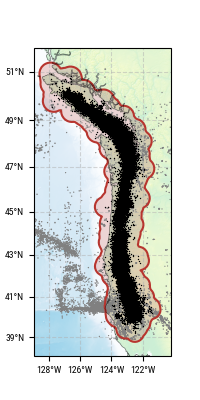

In [11]:
# Map
figsize = [2, 4]

with plt.style.context('grl'):
    fig, ax = plt.subplots(figsize=figsize, subplot_kw={'projection': crs})
    ax.set_extent([lon_min, lon_max, lat_min, lat_max])
    ax.coastlines(resolution='10m', zorder=10, color=to_rgba('k', .5), lw=.5)

    # Add ticks
    ax.set_xticks(np.arange(np.ceil(lon_min), lon_max+1, 2), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(np.ceil(lat_min), lat_max, 2), crs=ccrs.PlateCarree())
    ax.xaxis.set_major_formatter(LongitudeFormatter())
    ax.yaxis.set_major_formatter(LatitudeFormatter())
    ax.grid('on', linestyle='--', alpha=0.5)

    # Add physical features on the map
    data_sea = dem.copy()
    data_land = dem.copy()
    data_sea = data_sea.astype(float)
    data_land = data_land.astype(float)
    data_sea[data_sea > -10] = np.nan
    data_land[data_land < 10] = np.nan

    ls = mcolors.LightSource(azdeg=315, altdeg=45)
    sea_colors = plt.cm.Blues_r(np.linspace(.5, 1, 128))
    land_colors = plt.cm.YlGnBu_r(np.linspace(0.7, 1., 128))
    combined_colors = np.vstack((sea_colors, land_colors))
    mymap = mcolors.LinearSegmentedColormap.from_list('my_terrain', combined_colors)

    data_rgb = ls.shade(dem, cmap=mymap, blend_mode='soft', vert_exag=1, dx=dx, dy=dy, vmin=-5000, vmax=5000)
    ax.imshow(data_rgb, transform=ccrs.PlateCarree(), extent=[lon_min, lon_max, lat_min, lat_max], zorder=0)
    
    # Plot tremor
    ax.plot(trm[::10].lon, trm[::10].lat, 'o', transform=ccrs.PlateCarree(), ms=ms_trm_map, mfc=c_trm_map, mec='none', zorder=3)

    # Plot earthquakes
    eq_in_map = (eq.lon > lon_min) & (eq.lon < lon_max) & (eq.lat > lat_min) & (eq.lat < lat_max) & (eq.mag > min_mag)
    ax.scatter(eq[eq_in_map].lon, eq[eq_in_map].lat, transform=ccrs.PlateCarree(), s=eq[eq_in_map].mag/3, c=c_eq_map, edgecolor='none', zorder=2)

    # Show 50 km distance field
    ax.contour(dist_lon, dist_lat, dist_field, levels=[max_dist], colors=[sci_adv_red], transform=ccrs.PlateCarree(), zorder=4)
    ax.contourf(dist_lon, dist_lat, dist_field, levels=[0, max_dist], colors=[to_rgba(sci_adv_red, .2)], transform=ccrs.PlateCarree(), zorder=0)

    # # Show trench
    # ax.plot(phs_trench.lon, phs_trench.lat, transform=ccrs.PlateCarree(), c=to_rgba('k', .5), lw=2, zorder=2)
    # ax.plot(pac_trench.lon, pac_trench.lat, transform=ccrs.PlateCarree(), c=to_rgba('k', .5), lw=2, zorder=2)

    ax.set_extent([lon_min, lon_max, lat_min, lat_max])
    plt.show()

## Time series

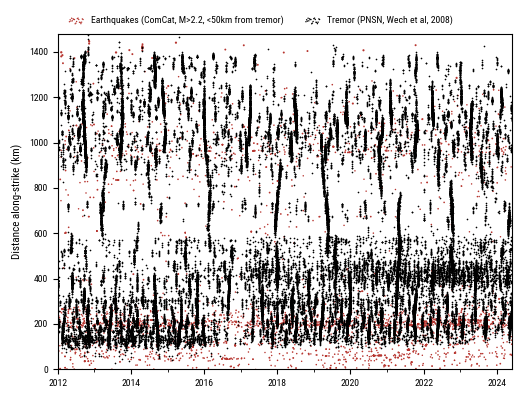

In [20]:
# Plot
figsize = [5.24, 4]
with plt.style.context('grl'):
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_ylabel('Distance along-strike (km)')

    ax.plot(trm[::10].date, trm[::10].xf, 'o', ms=1.2, mfc=c_trm_ts, mec='none', zorder=2)
    ax.scatter(eq[(eq.dist2trm < max_dist) & (eq.mag > min_mag)].date, eq[(eq.dist2trm < max_dist) & (eq.mag > min_mag)].xf, s=eq[(eq.dist2trm < max_dist) & (eq.mag > min_mag)].mag/2, c=[c_eq_ts], edgecolors='none', zorder=1)
    
    ax.set_xlim([np.datetime64('2012-01-01'), trm.date.max()])
    ax.set_ylim([trm.xf.min(), trm.xf.max()])

    # Legend
    ax.scatter([], [], s=1, c=[c_eq_ts], edgecolors='none', label=f'Earthquakes (ComCat, M>{min_mag:.1f}, <{max_dist:d}km from tremor)')
    ax.scatter([], [], s=1, c=[c_trm_ts], edgecolors='none', label='Tremor (PNSN, Wech et al, 2008)')
    ax.legend(bbox_to_anchor=(0, 1), loc='lower left', framealpha=.9, scatteryoffsets=.4 + np.random.randn(20)*.2, scatterpoints=20, handletextpad=.5, edgecolor='none', ncol=2)

    # Ticks
    ax.xaxis.set_major_locator(YearLocator(2))
    ax.xaxis.set_minor_locator(YearLocator(1))

    plt.tight_layout()
    plt.show()

# Main figure

In [21]:
# Parameters
figsize = (7.24, 4)

widths = (2, 5)

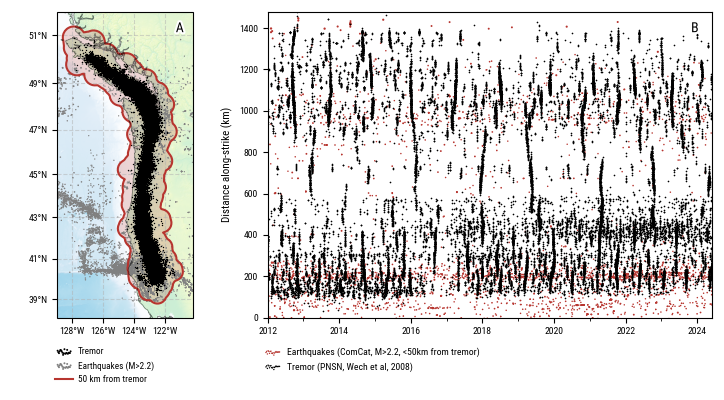

In [34]:
# Plot
with plt.style.context('grl'):
    fig = plt.figure(figsize=figsize, facecolor='.95')
    gs = fig.add_gridspec(1, 2, width_ratios=widths)

    # Map -------------------------------------------------------------------------------------------------
    ax = fig.add_subplot(gs[0], projection=crs)

    ax.set_extent([lon_min, lon_max, lat_min, lat_max])
    ax.coastlines(resolution='10m', zorder=10, color=to_rgba('k', .5), lw=.5)

    # Add ticks
    ax.set_xticks(np.arange(np.ceil(lon_min), lon_max+1, 2), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(np.ceil(lat_min), lat_max, 2), crs=ccrs.PlateCarree())
    ax.xaxis.set_major_formatter(LongitudeFormatter())
    ax.yaxis.set_major_formatter(LatitudeFormatter())
    ax.grid('on', linestyle='--', alpha=0.5)

    # Add physical features on the map
    data_sea = dem.copy()
    data_land = dem.copy()
    data_sea = data_sea.astype(float)
    data_land = data_land.astype(float)
    data_sea[data_sea > -10] = np.nan
    data_land[data_land < 10] = np.nan

    ls = mcolors.LightSource(azdeg=315, altdeg=45)
    sea_colors = plt.cm.Blues_r(np.linspace(.5, 1, 128))
    land_colors = plt.cm.YlGnBu_r(np.linspace(0.7, 1., 128))
    combined_colors = np.vstack((sea_colors, land_colors))
    mymap = mcolors.LinearSegmentedColormap.from_list('my_terrain', combined_colors)

    data_rgb = ls.shade(dem, cmap=mymap, blend_mode='soft', vert_exag=1, dx=dx, dy=dy, vmin=-5000, vmax=5000)
    ax.imshow(data_rgb, transform=ccrs.PlateCarree(), extent=[lon_min, lon_max, lat_min, lat_max], zorder=0)
    
    # Plot tremor
    ax.plot(trm[::10].lon, trm[::10].lat, 'o', transform=ccrs.PlateCarree(), ms=ms_trm_map, mfc=c_trm_map, mec='none', zorder=3, rasterized=True)

    # Plot earthquakes
    eq_in_map = (eq.lon > lon_min) & (eq.lon < lon_max) & (eq.lat > lat_min) & (eq.lat < lat_max) & (eq.mag > min_mag)
    ax.scatter(eq[eq_in_map].lon, eq[eq_in_map].lat, transform=ccrs.PlateCarree(), s=eq[eq_in_map].mag/3, c=c_eq_map, edgecolor='none', zorder=2, rasterized=True)

    # Show 50 km distance field
    ax.contour(dist_lon, dist_lat, dist_field, levels=[max_dist], colors=[sci_adv_red], transform=ccrs.PlateCarree(), zorder=4)
    ax.contourf(dist_lon, dist_lat, dist_field, levels=[0, max_dist], colors=[to_rgba(sci_adv_red, .2)], transform=ccrs.PlateCarree(), zorder=0)

    # # Show trench
    # ax.plot(phs_trench.lon, phs_trench.lat, transform=ccrs.PlateCarree(), c=to_rgba('k', .5), lw=2, zorder=2)
    # ax.plot(pac_trench.lon, pac_trench.lat, transform=ccrs.PlateCarree(), c=to_rgba('k', .5), lw=2, zorder=2)

    ax.set_extent([lon_min, lon_max, lat_min, lat_max])

    ax.scatter([], [], color=c_trm_map, edgecolors='none', s=2, label='Tremor')
    ax.scatter([], [], color=c_eq_map, edgecolors='none', s=2, label='Earthquakes (M>2.2)')
    ax.plot([], [], ls='-', c=sci_adv_red, label='50 km from tremor')
    ax.legend(loc='upper left', bbox_to_anchor=(-0.08, -.07), fontsize='small', framealpha=0, scatteryoffsets=.4 + np.random.randn(20)*.2, scatterpoints=20, handletextpad=.5, edgecolor='none')

    ax.text(.93, .97, 'A', fontsize=10, va='top', ha='right', transform=ax.transAxes,  path_effects=[fx.Stroke(linewidth=3, foreground='1.0'), fx.Normal()])


    # Time series -------------------------------------------------------------------------------------------------
    ax = fig.add_subplot(gs[1])
    ax.set_ylabel('Distance along-strike (km)')

    ax.plot(trm[::20].date, trm[::20].xf, 'o', ms=1.2, mfc=c_trm_ts, mec='none', zorder=2, rasterized=True)
    ax.scatter(eq[(eq.dist2trm < max_dist) & (eq.mag > min_mag)].date, eq[(eq.dist2trm < max_dist) & (eq.mag > min_mag)].xf, s=eq[(eq.dist2trm < max_dist) & (eq.mag > min_mag)].mag/2, c=[c_eq_ts], edgecolors='none', zorder=1, rasterized=True)
    
    ax.set_xlim([np.datetime64('2012-01-01'), trm.date.max()])
    ax.set_ylim([trm.xf.min(), trm.xf.max()])

    # Legend
    ax.scatter([], [], s=1, c=[c_eq_ts], edgecolors='none', label=f'Earthquakes (ComCat, M>{min_mag:.1f}, <{max_dist:d}km from tremor)')
    ax.scatter([], [], s=1, c=[c_trm_ts], edgecolors='none', label='Tremor (PNSN, Wech et al, 2008)')
    ax.legend(bbox_to_anchor=(-0.03, -.07), loc='upper left', framealpha=.9, scatteryoffsets=.4 + np.random.randn(20)*.2, scatterpoints=20, handletextpad=.5, edgecolor='none')

    # Ticks
    ax.xaxis.set_major_locator(YearLocator(2))
    ax.xaxis.set_minor_locator(YearLocator(1))

    ax.text(.97, .97, 'B', fontsize=10, va='top', ha='right', transform=ax.transAxes,  path_effects=[fx.Stroke(linewidth=3, foreground='1.0'), fx.Normal()])

    plt.tight_layout()
    plt.savefig('../figures/cascadia_main_figure.pdf')
    plt.savefig('../figures/cascadia_main_figure.png', dpi=300)
    plt.show()